In [1]:
using LinearAlgebra
using Statistics
using Plots

In [2]:
# helper methods
function symmetric_matrix(dim::Integer, show_matrix::Bool=false)::Matrix
    A = ones(dim,dim);
    for i = 1:dim
        for j = 1:i
            A[i,j] = rand(1:50);
            A[j,i] = A[i,j];
        end
    end
    if show_matrix
        display(A);
    end
    return A;
end

# we might change it to just rand(dim,dim)
function random_matrix(dim::Integer, show_matrix::Bool=false)::Matrix
    A = ones(dim, dim);
    for i = 1:dim
        for j = 1:dim
            A[i,j] = rand(1:50);
        end
    end
    if show_matrix
        display(A);
    end
    return A
end

function diagonal_matrix(dim::Integer)::Matrix
    Diag = ones(dim,dim)
    return Diagonal(Diag)
end

function eye(dim::Integer)::Matrix
    return Matrix{Float64}(I,n,n);
end


function custom_cond(λₘₐₓ, λₘᵢₙ)
    return sqrt(λₘₐₓ/λₘᵢₙ)
end

custom_cond (generic function with 1 method)

# Metoda potęgowa

Poniżej przygotowana jest funkcja do metody iteracji prostej (metoda potęgowa), dzięki której można wyznaczyć największą co do modułu wartość własną, czyli promień spektralny macierzy, który opisany jest wzorem:
## $$\rho(A) = |\lambda_{max}| = \lim_{i \to \infty} \frac{||t_{i+1}||_{\infty}}{||t_{i}||_{\infty}}$$

Przy założeniu, że dowolny wektor początkowy t_{0} != 0, do uzyskania promienia spektralnego prowadzą iteracje postaci:
## $$t_{i+1} = At_{i},\ i=0,1,2...$$



In [3]:
function power_eigen(A::Matrix, iterations::Integer)::Array
    n = size(A, 1);
    x = ones(n,1);
    x1 = x;
    
    for i = 1:iterations
        x1 = x;
        x = A * x;
        x = x / norm(x);
    end
    return x' * A * x1 / (x' * x1);
end

function power_eigen_min(A::Matrix, iterations::Integer)::Array
    n = size(A, 1);
    x = ones(n,1);
    x1 = x;
    for i = 1:iterations
        x1 = x;
        x = A \ x;
        x = x / norm(x);
    end

    return x' * A * x1 / (x' * x1);
end

power_eigen_min (generic function with 1 method)

In [4]:
A = symmetric_matrix(3);
#A = random_matrix(5);
#A = [22 21 -8 4; 21 49 11 39; -8 11 60 -19; 4 39 -19 135]
@time λₘₐₓ = power_eigen(A, 50);
@time λₘᵢₙ = power_eigen_min(A,50);
display(λₘₐₓ);
display(λₘᵢₙ);
e, v = eigen(A);
display(e);

  3.207499 seconds (6.63 M allocations: 322.237 MiB, 5.37% gc time)

1×1 Array{Float64,2}:
 78.05494167889546

1×1 Array{Float64,2}:
 -2.186371051391143

3-element Array{Float64,1}:
 -2.1863710513911414
 10.131429372495706
 78.05494167889533


  0.218710 seconds (405.04 k allocations: 20.121 MiB)


Jak widać z wyniku wykonania powyższego kodu, uzyskaliśmy największą co do modułu wartość własną macierzy. Ta wartość zgadza sięz wartością otrzymaną za pomocą metody eigen(A). Za pomocą metody potęgowej można również wyznaczyć najmniejszą co do modułu wartość własną macierzy. Korzysta się z twierdzenia dotyczącego przesunięcia spektrum macierzy:<br />
### "Jeżeli $\lambda$ jest wartością własną macierzy A, to $\lambda + r$ jest wartością własną macierzy $A + \tau I$"
Należy pamiętać, że twierdzenie ma zastosowanie dla macierzy symetrycznych i dodatnio określonych. Po zastosowaniu przesunięcia $B = A - \lambda_{max}I$ można ponownie zastosować metodę iteracji prostej dla macierzy B zbieżną do największej co do modułu wartości własnej $\lambda = \lambda_{min}-\lambda_{max}$. Stąd można wyznaczyć $\lambda_{min}$.

In [5]:
B = A' * A;
λₘₐₓ = power_eigen(B, 50);
n = size(A,1);
B_min = B - λₘₐₓ .* eye(n);
lambda_dash = power_eigen(B_min, 50);
λₘᵢₙ = lambda_dash + λₘₐₓ;

Mając największą i najmniejszą wartość własną macierzy, można wyznaczyć współczynnik uwarunkowania macierzy:
$$cond(A)=\sqrt{\frac{\lambda_{max}(A^TA)}{\lambda_{min}(A^TA)}}$$
We wzorze przyjęto, że macierz A jest symetryczna, co oznacza, że $A=A^T$, ewentualnie można macierz wejściową doprowadzić do postaci symetrycznej stosując wzór $B = A^TA$

In [6]:
value = custom_cond(λₘₐₓ, λₘᵢₙ)
print(value)

cond(A)

[10.731683401784178]

35.70068384743326

# Metoda Jacobiego

In [7]:
function jacobi_eigen(A::Matrix, iterations::Integer)::Matrix
    n = size(A,1);
    for i = 1:iterations
        s,t = maxst(A);
        
        d = √((A[s,s] - A[t,t])^2 + 4 * A[s,t]^2);
        sin2t = 2 * A[s,t] / d;
        cos2t = (A[s,s] - A[t,t]) / d;
        dt = sqrt(2 * (1 + cos2t));
        sint = abs(sin2t) / dt;
        cost = abs((1 + cos2t) / dt);
        cost = sign(A[s,t]) * cost;

        R = diagonal_matrix(n);
        R[s,s] = cost;
        R[t,t] = cost;
        R[s,t] = -sint;
        R[t,s] = sint;
        
        A = R' * A * R; 
        
    end
    return A
end

function maxst(A::Matrix)::Tuple{Integer,Integer}
    s = 1;
    t = 2;
    n = size(A,1);
    for c = 2:n
        for r = 1:c-1
            if abs(A[r,c]) > abs(A[s,t])
                s = r;
                t = c;
            end
        end
    end
    return s, t
end

maxst (generic function with 1 method)

In [8]:
#F = [12 6 -6 1; 6 16 2 100; -6 2 16 1 ;1 100 1 4];
#F = rand(4,4);
F = symmetric_matrix(5,true)
@time FJ = jacobi_eigen(F, 15);

n = size(FJ,1);
FJ = Diagonal(FJ)

display(FJ)
e,v = eigen(F);
display(e)


5×5 Array{Float64,2}:
 33.0  36.0   3.0  15.0  36.0
 36.0  26.0  23.0  36.0   8.0
  3.0  23.0   3.0  12.0  18.0
 15.0  36.0  12.0  18.0  14.0
 36.0   8.0  18.0  14.0  44.0

5×5 Diagonal{Float64,Array{Float64,1}}:
 111.458    ⋅        ⋅        ⋅          ⋅ 
    ⋅     36.1364    ⋅        ⋅          ⋅ 
    ⋅       ⋅      11.6087    ⋅          ⋅ 
    ⋅       ⋅        ⋅      -5.18795     ⋅ 
    ⋅       ⋅        ⋅        ⋅       -30.0151

5-element Array{Float64,1}:
 -30.017556211480745
  -5.1855085906737415
  11.606734350597584
  36.13517174359002
 111.46115870796658

  0.149152 seconds (275.04 k allocations: 14.544 MiB)


# QR algorithm

In [9]:
function QR_eigen(A::Matrix, iterations::Integer)::Matrix
    for k = 1:iterations
        Q, R = mgs(A);
        A = R * Q;
    end
    return A;
end

function mgs(A::Matrix)::Tuple{Matrix, Matrix}
    n = size(A,1);
    R = zeros(n,n);
    Q = zeros(n,n);
    for j = 1:n
        v = A[:,j];
        for i = 1:j-1
            R[i,j] = Q[:,i]' * v;
            v = v - R[i,j] * Q[:,i];
        end
        R[j,j] = norm(v);
        Q[:,j] = v / R[j,j];
    end

    return Q, R;
end

mgs (generic function with 1 method)

In [10]:
A = symmetric_matrix(5);
@time AQR = QR_eigen(A, 30);
Diag = Diagonal(AQR);
display(Diag);

e, v = eigen(A);
display(e)

5×5 Diagonal{Float64,Array{Float64,1}}:
 165.805     ⋅         ⋅        ⋅         ⋅ 
    ⋅     -16.9269     ⋅        ⋅         ⋅ 
    ⋅        ⋅      -12.4374    ⋅         ⋅ 
    ⋅        ⋅         ⋅      -9.57229    ⋅ 
    ⋅        ⋅         ⋅        ⋅       -0.868133

5-element Array{Float64,1}:
 -38.303411736444176
 -36.872558129945496
  -0.8681331605342493
  36.23933905426986
 165.80476397265372

  0.365534 seconds (727.51 k allocations: 35.989 MiB, 4.03% gc time)


# Wykresy

Poniższe wykresy prezentują zbieżność tylko dla największych wartości własnych, ponieważ metoda potęgowa wyznacza tylko pojedynczą wartość.

In [34]:
function plot_eigenvalues(PlotA::Matrix, min_iterations::Integer, max_iterations::Integer, show_all_in_one::Bool=false)
    if max_iterations < min_iterations
        return
    end

    x = min_iterations:max_iterations;
    results_power = zeros(0);
    results_jacobi = zeros(0);
    results_qr = zeros(0);
    results_eig = zeros(0);
    e, v = eigen(PlotA);
    eigen_lambda = maximum(abs, e);
    
    for i = min_iterations:max_iterations
        #power method
        val = power_eigen(PlotA,i);
        append!(results_power, val);
    
        # jacobi algorithm
        PlotAJ = jacobi_eigen(PlotA, i);
        PlotAJ = Diagonal(PlotAJ);
        val = maximum(abs, PlotAJ);
        append!(results_jacobi, val);
    
        # QR algorithm
        PlotAQR = QR_eigen(PlotA, i);
        PlotAQR = Diagonal(PlotAQR);
        val = maximum(abs, PlotAQR);
        append!(results_qr, val);
    
        # julia eigen()
        append!(results_eig, eigen_lambda)
    end
    
    results = hcat(results_eig, results_power, results_jacobi, results_qr);
    plot_all = plot(x, results, title= "Lambda max", label=["eigen" "power" "jacobi" "QR"], xlabel="iteracje", ylabel="wartosc lambda", ylim=(eigen_lambda*0.25, eigen_lambda*1.2));
    results = hcat(results_eig, results_power);
    plot_power = plot(x, results, title= "Lambda max", label=["eigen" "power"], xlabel="iteracje", ylabel="wartosc lambda");
    results = hcat(results_eig, results_jacobi);
    plot_jacobi = plot(x, results, title= "Lambda max", label=["eigen" "jacobi"], xlabel="iteracje", ylabel="wartosc lambda");
    results = hcat(results_eig, results_qr);
    plot_qr = plot(x, results, title= "Lambda max", label=["eigen" "QR"], xlabel="iteracje", ylabel="wartosc lambda");
    
    if !show_all_in_one
        #show plots separate 
        display(plot_all);
        display(plot_power);
        display(plot_jacobi);
        display(plot_qr);
    else
        # all plots together
        all_plots = plot(plot_all, plot_power, plot_jacobi, plot_qr, size = (800,800), layout = grid(4, 1, heights=[0.25 , 0.25, 0.25, 0.25]));
        display(all_plots);
    end
end

plot_eigenvalues (generic function with 4 methods)

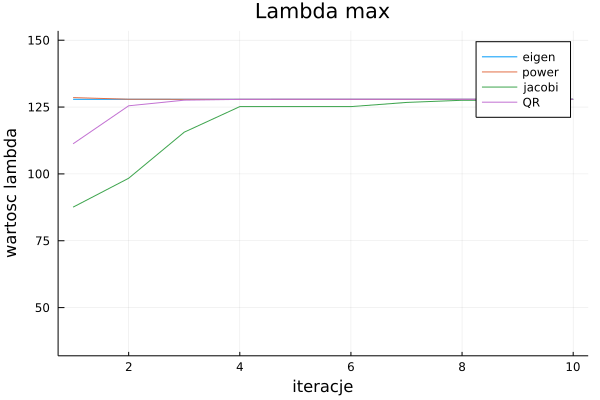

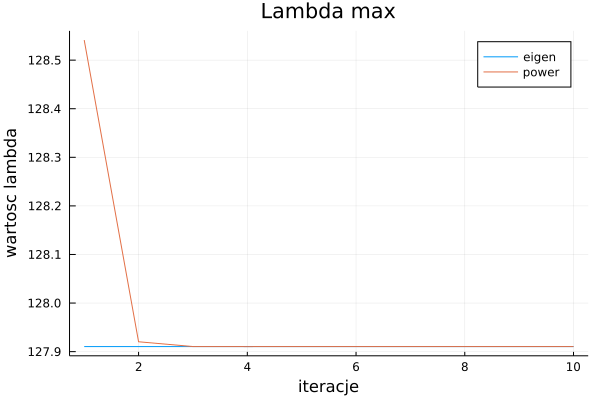

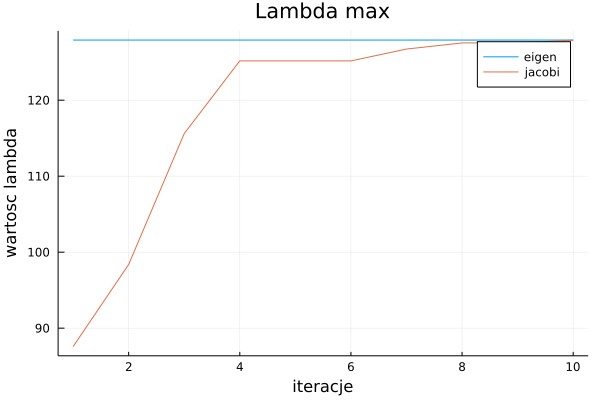

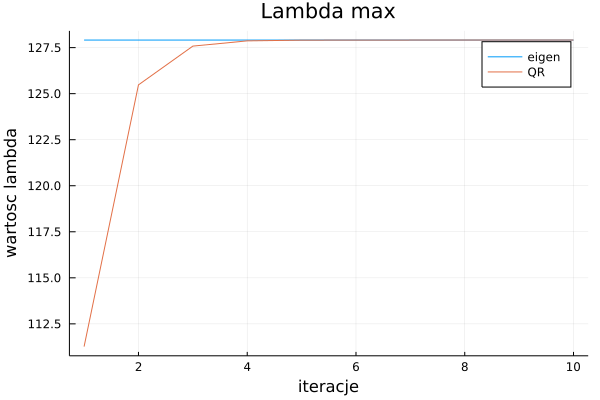

In [21]:
A = symmetric_matrix(5);
plot_eigenvalues(A, 1, 10);

## Przypadki testowe

metoda potęgowa - macierze o elementach i wartościach własnych rzeczywistych<br />
metoda Jacobiego - macierze symetryczne (w tym hermitowskie)<br />
algorytm QR - macierze niesymetryczne

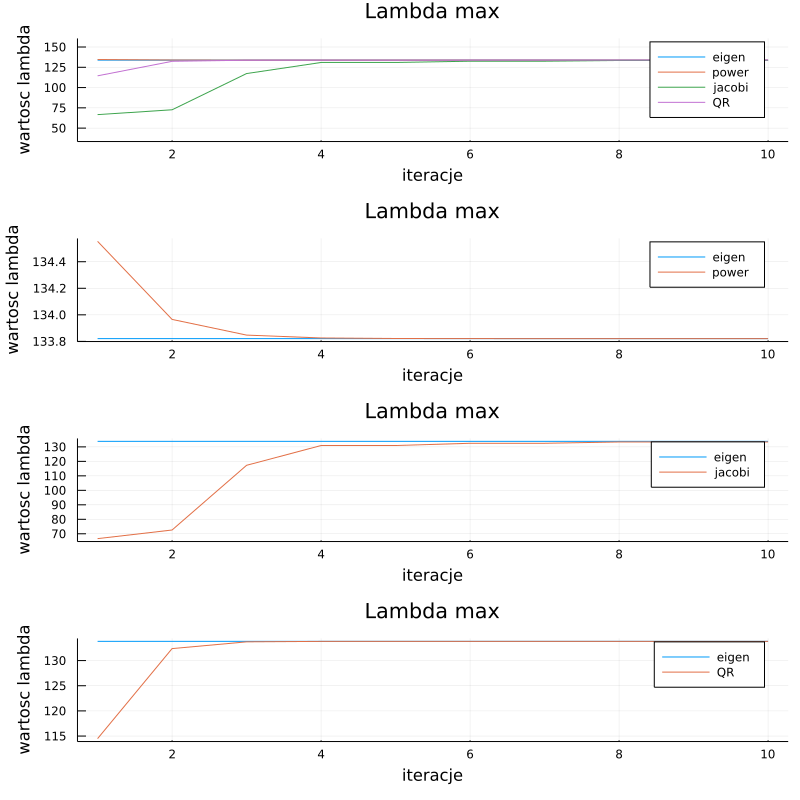

  0.082767 seconds (119.86 k allocations: 5.422 MiB)


In [24]:
Test1 = symmetric_matrix(5)
@time plot_eigenvalues(Test1, 1, 10, true)

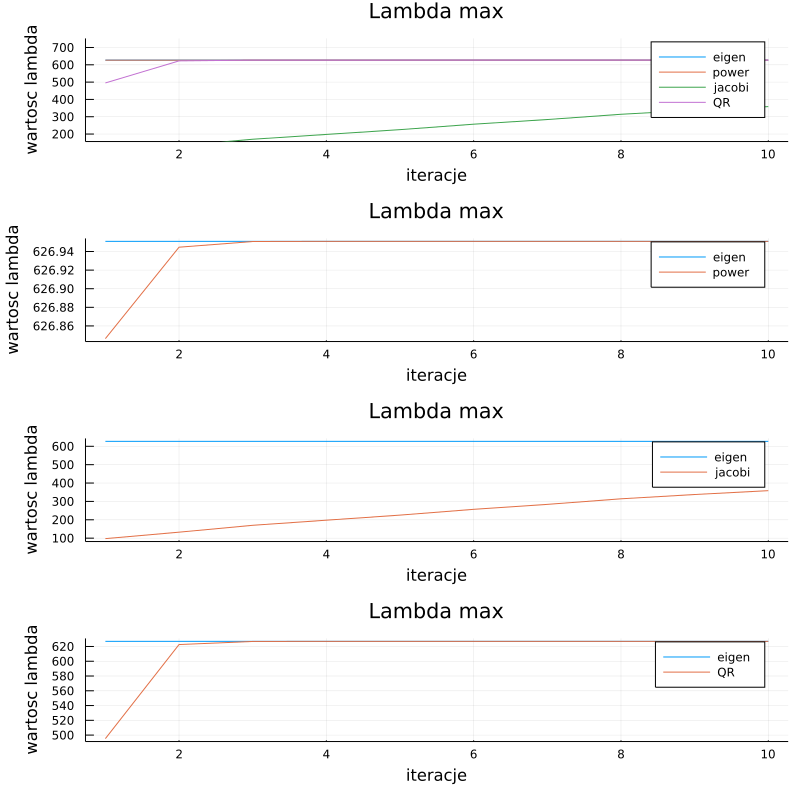

  0.106014 seconds (187.75 k allocations: 25.997 MiB)


In [25]:
Test2 = symmetric_matrix(25)
@time plot_eigenvalues(Test2, 1, 10, true)

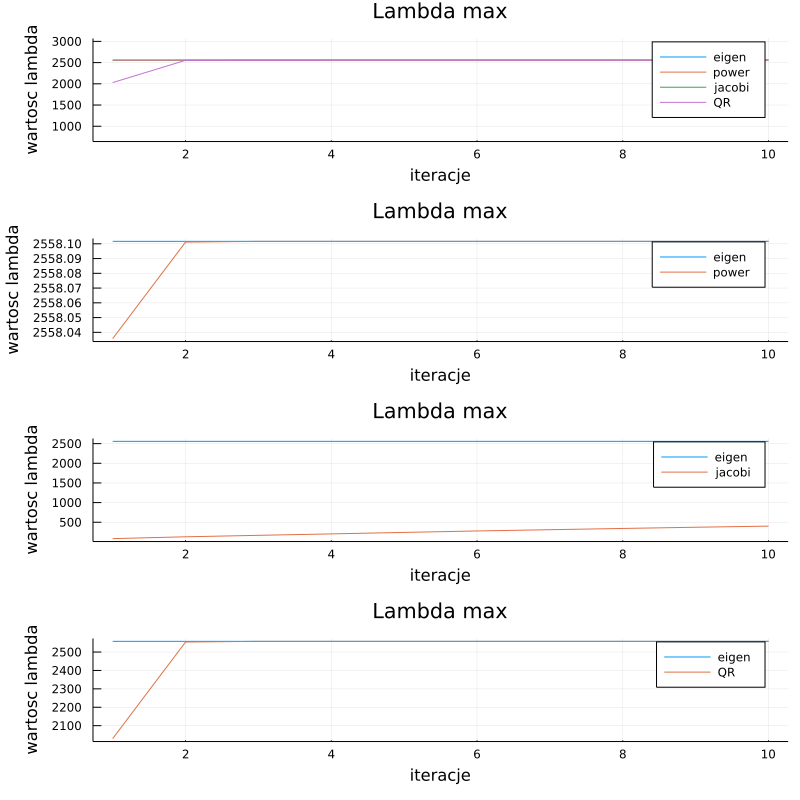

  1.221565 seconds (1.22 M allocations: 974.846 MiB, 20.13% gc time)


In [33]:
Test3 = symmetric_matrix(100)
@time plot_eigenvalues(Test3, 1, 10, true)